In [54]:
from scipy.io import loadmat
import os
import numpy as np
from sklearn import model_selection
from scipy.optimize import curve_fit
from sklearn import metrics
import matplotlib.pyplot as plt

# Load Data

In [2]:
DATA_FOLER = 'data'

In [59]:
x_json = loadmat(os.path.join(DATA_FOLER, 'example_calibrationfile.mat'))

In [60]:
print(x_json)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sat Mar  2 18:19:50 2019', '__version__': '1.0', '__globals__': [], 'I': array([[0.00099521, 0.00105729, 0.00112088, 0.00118454, 0.00124667,
        0.00130868, 0.00137242, 0.00143448, 0.00149659, 0.00156032,
        0.00162269, 0.00168476, 0.00174835, 0.00181034, 0.00187393,
        0.00193596, 0.00199956, 0.00206164, 0.00212377, 0.00218745,
        0.00224938, 0.0023115 , 0.00237345, 0.00243707, 0.00249894,
        0.00256253, 0.00262623, 0.00268835, 0.00275023, 0.00281396,
        0.00287595, 0.002938  , 0.00300171, 0.00306379, 0.00312593,
        0.00318798, 0.00325158, 0.00331557, 0.00337756, 0.00344112,
        0.00350323, 0.0035653 , 0.00362892, 0.0036909 , 0.0037529 ,
        0.00381501, 0.00387859, 0.00394075, 0.00400285, 0.00406805,
        0.00412996, 0.00419183, 0.00425558, 0.00431764, 0.00437968,
        0.00444323, 0.00450515, 0.00456718, 0.00462918, 0.00469295,
        0.00475646, 0.00481846, 0.00488212,

In [61]:
current = x_json['I']
topmw = x_json['TopmW']

In [62]:
print(current.shape)
print(topmw.shape)

(1, 354)
(1, 354)


In [63]:
current = np.squeeze(current)
topmw = np.squeeze(topmw)

In [64]:
print(current.shape)
print(topmw.shape)

(354,)
(354,)


# Curve Fitting

## Split Training and Testing Data

In [65]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(current, topmw, test_size=0.25, random_state=3)

In [138]:
yy_train = np.arccos(y_train * 2 - 1) 
yy_test = np.arccos(y_test * 2 - 1)

## Training 

#### Current to Power

In [213]:
def polynomial5(x, a, b, c, d):
    p = a * x**5 + b * x ** 4 + c * x**3 + d * x**2
    return p

def polynomial3(x, c, d):
    p = d * x**3 + c * x**2
    return p

#### Make Sure Power Value is Between 0 and Pi

In [214]:
def num_to_pi(num):
    
    if num > np.pi * 2:
        num = num % (np.pi * 2)
    
    if num < 0:
        num = np.ceil(np.abs(num) // (np.pi * 2)) * np.pi * 2 + num
        
    if num > np.pi:
        num = 2 * np.pi - num
        
    return num

vfunc_num_to_pi = np.vectorize(num_to_pi)

#### Fitting Curve

In [216]:
def func(x, c, d, alpha, beta):
    p = polynomial3(x, c, d)
    phi = alpha * p + beta
    
    phi = vfunc_num_to_pi(phi)

    return phi

In [217]:
popt, pcov = curve_fit(func, x_train, yy_train)

### Parameter!

In [218]:
popt

array([  47.81804129, 1512.16292669,  284.68352717,    3.28652786])

### Training r2

In [219]:
metrics.r2_score(yy_train,  func(x_train, *popt))

0.9278099815780669

### Plot Training Data with Fitted Curve

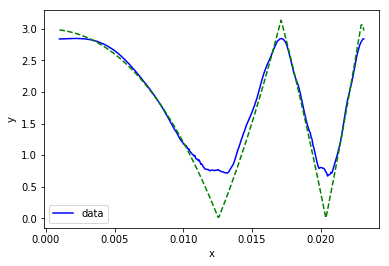

In [221]:
sort_indices = np.argsort(x_train)

plt.plot(x_train[sort_indices], yy_train[sort_indices], 'b-', label='data')
plt.plot(x_train[sort_indices], func(x_train[sort_indices], *popt), 'g--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Testing

In [222]:
yy_pred = func(x_test, *popt)

### Testing R2

In [223]:
metrics.r2_score(yy_test, yy_pred)

0.9101932116964406

### Plot Test Data with Fitted Curve

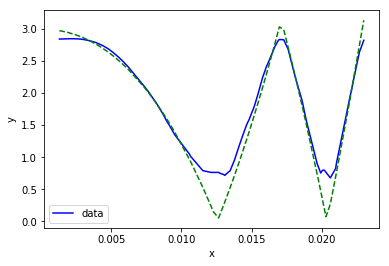

In [224]:
sort_indices = np.argsort(x_test)

plt.plot(x_test[sort_indices], yy_test[sort_indices], 'b-', label='data')
plt.plot(x_test[sort_indices], func(x_test[sort_indices], *popt), 'g--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()